In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('./reduced_model_ETC_core_20250228-213124_continuous_steady_state_fuel_competition_10_fold.csv')

In [ ]:
# Load only the robust parameters samples
from skimpy.core.parameters import load_parameter_population
parameter_population = load_parameter_population('./reduced_model_ETC_core_20250228-213124_tfa_sampling_pruned_parameters.hdf5')


In [3]:
# Prin the head for the net fluxes of LDH_L, LDH_Lm, PYRt2m, 
df[['LDH_L', 'LDH_Lm', 'PYRt2m','L_LACt2r','L_LACtm','parameter','pertubration']].head()

,LDH_L,LDH_Lm,PYRt2m,L_LACt2r,L_LACtm,parameter,pertubration
0,-0.157292,0.054401,0.051659,-0.102890,0.054401,lac_L_e,0.100000
1,-0.158056,0.056574,0.050888,-0.101482,0.056574,lac_L_e,0.125893
2,-0.158949,0.059219,0.049986,-0.099730,0.059219,lac_L_e,0.158489
3,-0.159972,0.062424,0.048954,-0.097548,0.062424,lac_L_e,0.199526
4,-0.161111,0.066294,0.047802,-0.094817,0.066294,lac_L_e,0.251189


In [4]:
# Compute glucose and lactate oxidation rates 
# vnet = vfwd - vback and vback/vfwd = gamma 
# vbwd = vent * gamma / (1 - gamma)
# vfwd = vent / (1 - gamma)
df['LDH_L_Keq'] = df.apply(lambda x: parameter_population[x['parameter_set']]['k_equilibrium_LDH_L'], axis=1)
df['LDH_L_gamma'] = 1 / (1 / df['LDH_L_Keq'] * df['pyr_c'] * df['nadh_c'] * df['h_c'] / (df['lac_L_c'] * df['nad_c']))  # Thermodynamics displacement
# if neg invert forward and reverse
df['LDH_L_rvs'] =  -1 * df['LDH_L'] * df['LDH_L_gamma'] / (1 - df['LDH_L_gamma'])
df['LDH_L_fwd'] =  -1 * df['LDH_L'] / (1 - df['LDH_L_gamma'])

# Same for LDH_Lm
df['LDH_Lm_Keq'] =  df.apply(lambda x: parameter_population[x['parameter_set']]['k_equilibrium_LDH_Lm'], axis=1)
df['LDH_Lm_gamma'] = 1 / df['LDH_Lm_Keq'] * df['pyr_m'] * df['nadh_m'] * df['h_m'] / (df['lac_L_m'] * df['nad_m'])  # Thermodynamics displacement
df['LDH_Lm_fwd'] =  df['LDH_Lm'] / (1 - df['LDH_Lm_gamma'])
df['LDH_Lm_rvs'] =  df['LDH_Lm'] * df['LDH_Lm_gamma'] / (1 - df['LDH_Lm_gamma']) 

# Same for pyruvate transport
df['PYRt2m_Keq'] = df.apply(lambda x: parameter_population[x['parameter_set']]['k_equilibrium_PYRt2m'], axis=1)
df['PYRt2m_gamma'] =  1 / df['PYRt2m_Keq'] * df['pyr_m'] * df['h_m'] / (df['pyr_c'] * df['h_c'])  # Thermodynamics displacement
df['PYRt2m_fwd'] = df['PYRt2m']/ (1 - df['PYRt2m_gamma'])
df['PYRt2m_rvs'] =  df['PYRt2m']  * df['PYRt2m_gamma']  / (1 - df['PYRt2m_gamma'])

# Lactate transport to cyto
df['L_LACt2r_Keq'] = df.apply(lambda x: parameter_population[x['parameter_set']]['k_equilibrium_L_LACt2r'], axis=1)
df['h_e'] = df.apply(lambda x: parameter_population[x['parameter_set']]['h_e'], axis=1)
df['lac_L_e']= df.apply(lambda x: parameter_population[x['parameter_set']]['lac_L_e'], axis=1)
df['lac_L_e_mod'] = df.apply(lambda x: x['lac_L_e'] * (x['pertubration']) if 'lac_L_e' == x['parameter'] else x['lac_L_e'], axis=1)  # change lac_L_e based on the perturbation if lac_L_e is in parameter columns of df
# change lac_L_e based on the perturbation if lac_L_e is in parameter columns of df 
df['L_LACt2r_gamma'] = 1.0/ (1.0 / df['L_LACt2r_Keq'] * df['lac_L_c'] * df['h_c'] / (df['lac_L_e_mod'] * df['h_e']))  # Thermodynamics displacement
df['L_LACt2r_rvs'] = -1 * df['L_LACt2r'] * df['L_LACt2r_gamma'] / (1 - df['L_LACt2r_gamma'])
df['L_LACt2r_fwd'] = -1 * df['L_LACt2r'] / (1 - df['L_LACt2r_gamma'])


# Lacgate transport to mito 
df['L_LACtm_Keq'] = df.apply(lambda x: parameter_population[x['parameter_set']]['k_equilibrium_L_LACtm'], axis=1)
df['L_LACtm_gamma'] = 1.0 / df['L_LACtm_Keq'] * df['lac_L_m'] * df['h_m'] / (df['lac_L_c'] * df['h_c'])  # Thermodynamics displacement
df['L_LACtm_fwd'] = df['L_LACtm'] / (1 - df['L_LACtm_gamma'])
df['L_LACtm_rvs'] = df['L_LACtm'] * df['L_LACtm_gamma'] / (1 - df['L_LACtm_gamma'])


In [5]:
# Rename some things for simplicity
df['gly'] = df['PYK']

df['ltf'] = df['L_LACt2r_fwd'] 
df['ltr'] = df['L_LACt2r_rvs']

df['ldhf'] = df['LDH_L_fwd']
df['ldhr'] = df['LDH_L_rvs']

df['lmtf'] = df['L_LACtm_fwd']
df['lmtr'] = df['L_LACtm_rvs']

df['ptf'] = df['PYRt2m_fwd']
df['ptr'] = df['PYRt2m_rvs']

df['ldhmf'] = df['LDH_Lm_fwd']
df['ldhmr'] = df['LDH_Lm_rvs']

df['pdh'] = df['PDHm']

In [6]:


# # Expression for glucose oxidation graction (contribition of glucose to mit pyruvate)
# (gly (ldhf ldhmf ltmf + ldhmf (ldhr + ltf + ltmf) ptf + (ldhr + ltf) ltmr ptf))/
# ((ldhmr ltf ltmr + ldhmf (ldhr + ltf + ltmf) pdh + (ldhr + ltf) ltmr pdh) ptf 
#   + ldhf (ldhmr ltf ltmr + ldhmf (ltf + ltmf) pdh + ltf ltmr pdh + ltf (ldhmf + ltmr) ptr))

df['glucose_pyruvate'] = (
    (df['gly'] * (df['ldhf'] * df['ldhmf'] * df['lmtf'] 
     + df['ldhmf'] * (df['ldhr'] + df['ltf'] + df['lmtf']) * df['ptf'] 
     + (df['ldhr'] + df['ltf']) * df['lmtr'] * df['ptf'])) 
     / 
     ((df['ldhmr'] * df['ltf'] * df['lmtr'] +  df['ldhmf'] * (df['ldhr'] + df['ltf'] + df['lmtf']) * df['pdh'] 
       + (df['ldhr'] + df['ltf']) * df['lmtr'] * df['pdh']) * df['ptf'] +
    df['ldhf'] * (df['ldhmr'] * df['ltf'] * df['lmtr'] + df['ldhmf'] * (df['ltf'] + df['lmtf']) * df['pdh'] 
                  + df['ltf'] * df['lmtr'] * df['pdh'] + df['ltf'] * (df['ldhmf'] + df['lmtr']) * df['ptr']))) 


# # Expression for lactate oxidation graction (contribition of lactate to mit pyruvate)
# (ltr (ldhf ldhmf ltmf + ldhmf (ldhr + ltmf) ptf +
#      ldhr ltmr ptf))/((ldhmr ltf ltmr +
#       ldhmf (ldhr + ltf + ltmf) pdh + (ldhr + ltf) ltmr pdh) ptf +
#    ldhf (ldhmr ltf ltmr + ldhmf (ltf + ltmf) pdh + ltf ltmr pdh +
#       ltf (ldhmf + ltmr) ptr))


df['lactate_pyruvate'] =  ((df['ltr'] * (df['ldhf'] * df['ldhmf'] * df['lmtf'] +
                                df['ldhmf'] * (df['ldhr'] + df['lmtf']) * df['ptf'] +
                                df['ldhr'] * df['lmtr'] * df['ptf'])) / (
    (df['ldhmr'] * df['ltf'] * df['lmtr'] +
     df['ldhmf'] * (df['ldhr'] + df['ltf'] + df['lmtf']) * df['pdh'] +
     (df['ldhr'] + df['ltf']) * df['lmtr'] * df['pdh']) * df['ptf'] +
    df['ldhf'] * (df['ldhmr'] * df['ltf'] * df['lmtr'] +
                  df['ldhmf'] * (df['ltf'] + df['lmtf']) * df['pdh'] +
                  df['ltf'] * df['lmtr'] * df['pdh'] +
                  df['ltf'] * (df['ldhmf'] + df['lmtr']) * df['ptr']))) 


In [7]:
df['lactate_ox'] = df['lactate_pyruvate'] * df['pdh']  # Lactate oxidation rate is lactate pyruvate flux times PDHm
df['glucose_ox'] = df['glucose_pyruvate'] * df['pdh'] / 2  # Glucose oxidation rate is glucose pyruvate flux times PDHm

In [8]:
uptake_fluxes = ['glucose_ox', 'lactate_ox', 'HDCAtr', 'BHBt']
n_carbons = [6, 3, 16, 4]  # Number of carbons in each uptake flux

In [9]:
# Scaling parameters
CONCENTRATION_SCALING = 1e3 # 1 mol to 1 mmol
TIME_SCALING = 1.0 # 1min
DENSITY = 1200 # g/L 
GDW_GWW_RATIO = 1.0 # Fluxes are in gWW

# To test how close to zero the dxdt is
flux_scaling_factor = 1e-6 / (GDW_GWW_RATIO / DENSITY) \
                        * CONCENTRATION_SCALING \
                        / TIME_SCALING


In [10]:
# Flux constraints for the core model 
RER = 0.79
fraction_of_whole_body_o2 = 0.7

o2_uptake = 2.0 * fraction_of_whole_body_o2 
co2_production = o2_uptake * RER 

# Total amount of CO2 produced for a 25g STD mouse 
co2_production/0.8/0.8 * 25 # umol/min

43.20312499999999

In [11]:
# Scale data 
for i, (uptake_flux, nc) in enumerate(zip(uptake_fluxes, n_carbons)):
    df.loc[:,uptake_flux] = df.loc[:,uptake_flux] * nc

In [12]:
# Compute the change for a ten fold perturbation 

results = {}

# Estimate the slope # at fold changes based on x0.5 and x2.0 perturbations
p1 = df['pertubration'].unique()[5]
p0 = df['pertubration'].unique()[10]
p2 = df['pertubration'].unique()[15]


for perturbation in ['glc_D_e', 'lac_L_e', 'hdca_e', 'bhb_e']:

    # Uptake fluxes at low perturbation
    uptake_flux_low = df.loc[(df['pertubration'] == p1)  & (df['parameter'] == perturbation)][uptake_fluxes].reset_index(drop=True)
    # Uptake fluxes at high perturbation
    uptake_flux_high = df.loc[(df['pertubration'] == p2)  & (df['parameter'] == perturbation)][uptake_fluxes].reset_index(drop=True)
    # Uptake fluxes at reference
    uptake_flux_medium = df.loc[(df['pertubration'] == p0)  & (df['parameter'] == perturbation)][uptake_fluxes].reset_index(drop=True)

    # Compute the log slope
    slope = (uptake_flux_high - uptake_flux_low) / (p2 - p1) * p0 / uptake_flux_medium

    # Log the parameter sets 
    index_parameters_set = df.loc[(df['pertubration'] == p0)  & (df['parameter'] == perturbation)]['parameter_set'].reset_index(drop=True)
    
    results[perturbation] = slope


# Horizontally concatenate the results into a DataFrame 
# rename the columns to include the perturbation name
for k, v in results.items():
    v.columns = [f"{k}_{col}" for col in v.columns]

results_df = pd.concat(results.values(), axis=1)


# Add parameter set index to the results DataFrame
results_df['parameter_set'] = index_parameters_set.reset_index(drop=True)



In [13]:
# Sort them based on the order of the fold changes 
order = [
    'glc_D_e_glucose_ox', 'lac_L_e_lactate_ox', 'hdca_e_HDCAtr', 'bhb_e_BHBt',
    'glc_D_e_lactate_ox', 'glc_D_e_HDCAtr', 'glc_D_e_BHBt',
    'lac_L_e_glucose_ox', 'lac_L_e_HDCAtr', 'lac_L_e_BHBt',
    'hdca_e_glucose_ox', 'hdca_e_lactate_ox', 'hdca_e_BHBt',
    'bhb_e_glucose_ox', 'bhb_e_lactate_ox', 'bhb_e_HDCAtr',
    ]


sensitivities_simple = np.array( 
       [0.89622097, 0.80097167, 0.39160331,  0.91040174,  
        -0.10358208,-0.10358208,-0.10358208, 
        -0.19869065, -0.19869065, -0.19869065, 
        -0.6078915 ,  -0.6078915 , -0.6078915,
        -0.08942555, -0.08942555, -0.08942555,
       ])


distance = ((results_df[order] - sensitivities_simple)).apply(lambda x: x**2, axis=1).sum(axis=1).apply(lambda x: np.sqrt(x))
# # Cosine distance
# from sklearn.metrics.pairwise import cosine_distances
# distance = cosine_distances(results_df[order], [sensitivities_simple])
# distance = pd.Series(distance.flatten(), index=results_df.index)

# Rank the index by distance
sorted_index = distance.sort_values(ascending=True).index

In [14]:

# Load the from the competitive catboalism formula
competitive_catabolism_data = pd.read_csv('../../minimal_model/output/competitive_catabolism_rates.csv')

# Map rate names 
mapping_dict = {
    'Glucose oxidation': 'glucose_ox',
    'Lactate oxidation': 'lactate_ox',
    'Fatty acids oxidation': 'HDCAtr',
    'Ketones oxidation': 'BHBt',
    }

competitive_catabolism_data['uptake_flux'] = competitive_catabolism_data['Rate'].map(mapping_dict)

# Mapp metabolites 
mapping_metabolites = {
    'Glucose': 'glc_D_e',
    'Lactate': 'lac_L_e',
    'Fatty acids': 'hdca_e',
    'Ketones': 'bhb_e',
}

competitive_catabolism_data['serum_conc'] = competitive_catabolism_data['Metabolite'].map(mapping_metabolites)

In [15]:
#uptake_fluxes = ['GLCt1r','glucose_ox', 'lactate_ox', 'HDCAtr', 'BHBt']

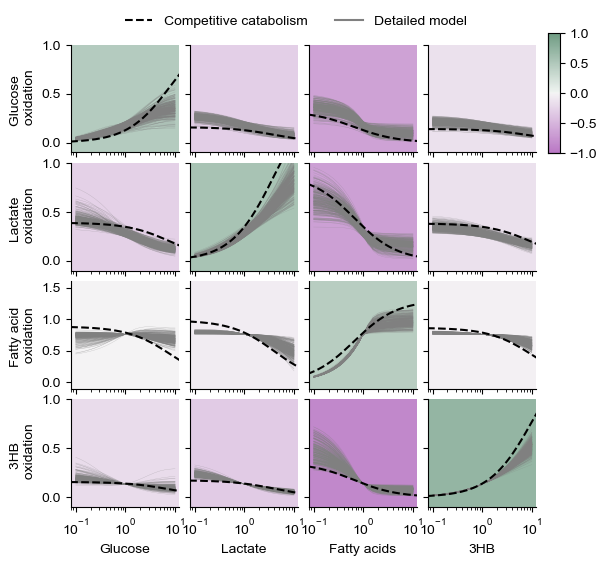

In [ ]:
# Import the plotting library
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 10, 'font.family': 'Arial'})


# Plot in a 4x4 grid 
# Parameter changes 
serum_concentrations = ['glc_D_e', 'lac_L_e', 'hdca_e', 'bhb_e', ]
 
# Y-Lables
ylabel = { 
            'GLCt1r': 'Glucose \n uptake',
            'glucose_ox': 'Glucose \n oxidation',
            'lactate_ox': 'Lactate \n oxidation', 
            'HDCAtr': 'Fatty acid \n oxidation ', 
            'BHBt': '3HB \n oxidation'} 

# X-Lables
xlabel = {'glc_D_e': 'Glucose', 
          'lac_L_e': 'Lactate', 
          'hdca_e': 'Fatty acids', 
          'bhb_e': '3HB'}

# Y limits for the respective uptake fluxes
ylim = {
    'GLCt1r': (-0.1, 1.0),
    'glucose_ox': (-0.1, 1.0),
    'lactate_ox': (-0.1, 1.),
    'HDCAtr': (-0.1, 1.6),
    'BHBt': (-0.1, 1.0)
}

cmap = sns.diverging_palette(300,145, s=60, as_cmap=True)

# Make a grid of line plots share y-axis per row 
fig, axs = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey='row')
# Color the background of the plots as a heat map of the slope arround 0 perturbation
plt.subplots_adjust(wspace=0.1, hspace=0.1)


for i, (uptake_flux, nc) in enumerate(zip(uptake_fluxes, n_carbons)):
    for j, serum_concentration in enumerate(serum_concentrations):
        this_data = df[df['parameter'] == serum_concentration].copy() 
        ax = axs[i, j]
        
        # Plot the competitive catabolism data
        # Select the data metabolite, and rate 
        this_competitive_data = competitive_catabolism_data[
            (competitive_catabolism_data['serum_conc'] == serum_concentration) & 
            (competitive_catabolism_data['uptake_flux'] == uptake_flux)
        ]
        
        # Down sample by 10 
        parameters_sets_downsampled = this_data.parameter_set.unique()[::10]
        this_data = this_data[this_data['parameter_set'].isin(parameters_sets_downsampled)]

        sns.lineplot(data=this_data, x='pertubration', y=uptake_flux, 
                ax=ax, color='grey', 
                units="parameter_set",
                estimator=None,
                linewidth=0.2,
                alpha=0.5,
            )


        # Dashed line for the competitive catabolism data
        sns.lineplot(data=this_competitive_data, 
                     x='Concentration relative to reference', 
                     y='Rate (mmol/min/gBW)', 
                     ax=ax, 
                     errorbar=('pi',50), 
                     estimator='median', 
                     linestyle='--',
                     legend=False,
                     color='black',
                     )
        
        ax.set_xscale('log')
        
        # Horizontal line for 0 
        # ax.axhline(0, color='gray', linestyle='--')
        axs[i, j].set_ylim(ylim[uptake_flux])

        # Estimate the slope 
        p1 = df['pertubration'].unique()[7]
        p0 = df['pertubration'].unique()[10]
        p2 = df['pertubration'].unique()[13]

        dy = (this_data[this_data['pertubration'] == p2][uptake_flux].reset_index(drop=True) - this_data[this_data['pertubration'] == p1][uptake_flux].reset_index(drop=True)).median()
        y = this_data[this_data['pertubration'] == p0][uptake_flux].reset_index(drop=True).median()

        dp = p2-p1
        slope = dy/dp/y
        scaled_epsilon = (slope + 1.0) / 2.0
        facecolor = cmap(scaled_epsilon)

        axs[i, j].set_facecolor(facecolor)      
        axs[i, j].patch.set_alpha(0.8)  

        # Only show the x-axis label and tick labels on the bottom row
        if i == 3:
            ax.set_xlabel(xlabel[serum_concentration])
        else:
            ax.set_xlabel('')
        
        # Only show the y-axis label and tick labels on the left column
        if j == 0:
            ax.set_ylabel(ylabel[uptake_flux])
        else:
            ax.set_ylabel('')


# Align the y-axis labels to left
fig.align_ylabels(axs[:, 0])

# Set y-ticks of the fatty acid oxidation to be 0.5, 1.0, 1.5
axs[2, 1].set_yticks([0.0, 0.5, 1.0, 1.5])
# Set x lims 
axs[3, 0].set_xlim(0.1*0.8, 10.0*1.2)

# Add a small colorbar in the right corner
cbar_ax = fig.add_axes([0.92, 0.7, 0.02, 0.2])
norm = plt.Normalize(vmin=-1.0, vmax=1.0)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, alpha=0.8)

# Add a legend with two lines, one for the competitive catabolism data and one for the model data   
handles = [
    plt.Line2D([0], [0], color='black', linestyle='--', label='Competitive catabolism'),
    plt.Line2D([0], [0], color='grey', linestyle='-', label='Detailed model')
]

fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.95), fontsize=10, frameon=False)

sns.despine()

plt.savefig('./output/literature_regulation_sensitivity_to_fuel_perturbations_all.svg', bbox_inches='tight')


In [22]:
# Find the parameter set with the smallest distance to the median
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

#1 computte the median of the results_df
median_results = df.groupby(['pertubration','parameter'])[uptake_fluxes].median().reset_index()

#2 compute the distance of each parameter set to the median
distance_to_median = {}
for this_parameter in tqdm(df['parameter_set'].unique()):
    this_results = df[df['parameter_set'] == this_parameter]
    # Get the data and flaten 
    this_results_flat = this_results[uptake_fluxes]
    median_results_flat = median_results[uptake_fluxes]
    # Sort the dataframes by pertubration and parameter to ensure the same order
    this_results_flat = this_results_flat.set_index(this_results[['pertubration','parameter']].apply(tuple, axis=1)).sort_index()
    median_results_flat = median_results_flat.set_index(median_results[['pertubration','parameter']].apply(tuple, axis=1)).sort_index()    
    # Compute the distance
    mse = r2_score(this_results_flat, median_results_flat)
    
    distance_to_median[this_parameter] = mse

#3 find the parameter set with the smallest distance to the median
representative_parameter_set = max(distance_to_median, key=distance_to_median.get) 


100%|██████████| 3108/3108 [00:38<00:00, 81.44it/s]


In [23]:
representative_parameter_set, distance_to_median[representative_parameter_set]

('191,1', 0.9965338319697825)

Text(0.5, 0, 'Mean Squared Error to Median')

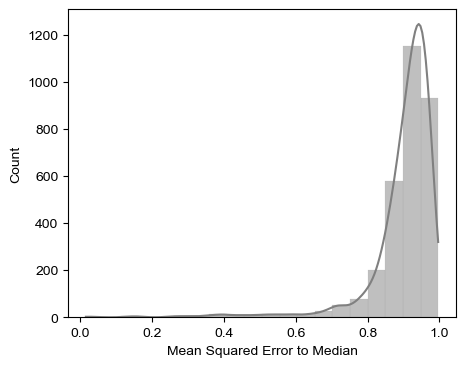

In [24]:
# Plot the distribution of distance_to_median
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5, 4))
sns.histplot(list(distance_to_median.values()), bins=20, kde=True, color='grey',
              alpha=0.5, edgecolor='darkgrey', linewidth=0.1, )
plt.xlabel('Mean Squared Error to Median')

In [25]:

#Only keep in parameter set index the ones that are in the competitive catabolism data
df = df[df['parameter_set'].isin([representative_parameter_set,])]

In [26]:
# Save best parameter sets
#df.to_csv('fuel_competition_best_10_parameter_sets.csv', index=False)
# df.to_csv('fuel_competition_random_10_parameter_sets.csv', index=False)
df.to_csv('fuel_competition_rep_parameter_sets.csv', index=False)


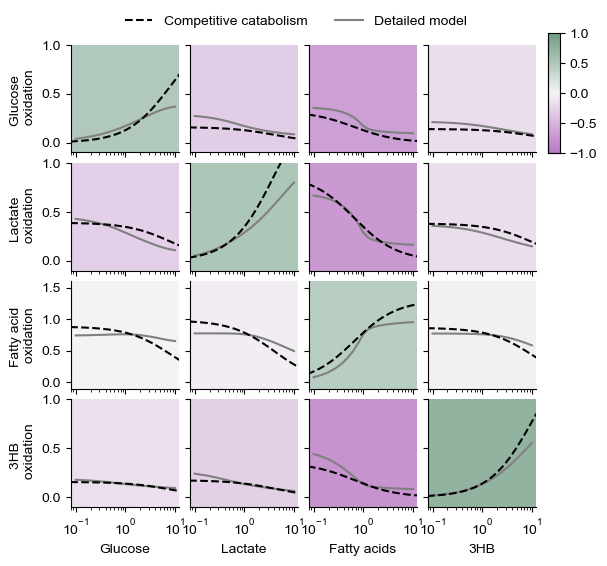

In [ ]:
# Import the plotting library
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 10, 'font.family': 'Arial'})


# Plot in a 4x4 grid 
# Parameter changes 
serum_concentrations = ['glc_D_e', 'lac_L_e', 'hdca_e', 'bhb_e', ]
 
# Y-Lables
ylabel = { 
            'glucose_ox': 'Glucose \n oxidation',
            'lactate_ox': 'Lactate \n oxidation', 
            'HDCAtr': 'Fatty acid \n oxidation ', 
            'BHBt': '3HB \n oxidation'} 

# X-Lables
xlabel = {'glc_D_e': 'Glucose', 
          'lac_L_e': 'Lactate', 
          'hdca_e': 'Fatty acids', 
          'bhb_e': '3HB'}

# Y limits for the respective uptake fluxes
ylim = {
    'glucose_ox': (-0.1, 1.0),
    'lactate_ox': (-0.1, 1.),
    'HDCAtr': (-0.1, 1.6),
    'BHBt': (-0.1, 1.0)
}

cmap = sns.diverging_palette(300,145, s=60, as_cmap=True)


# Make a grid of line plots share y-axis per row 
fig, axs = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey='row')
# Color the background of the plots as a heat map of the slope arround 0 perturbation
plt.subplots_adjust(wspace=0.1, hspace=0.1)


for i, (uptake_flux, nc) in enumerate(zip(uptake_fluxes, n_carbons)):
    for j, serum_concentration in enumerate(serum_concentrations):
        this_data = df[df['parameter'] == serum_concentration].copy() 
        ax = axs[i, j]
        
        # Plot the competitive catabolism data
        # Select the data metabolite, and rate 
        this_competitive_data = competitive_catabolism_data[
            (competitive_catabolism_data['serum_conc'] == serum_concentration) & 
            (competitive_catabolism_data['uptake_flux'] == uptake_flux)
        ]
        

        
        sns.lineplot(data=this_data, x='pertubration', y=uptake_flux, 
                ax=ax, color='grey', 
                units="parameter_set",
                estimator=None,
            )

        # Dashed line for the competitive catabolism data
        sns.lineplot(data=this_competitive_data, 
                     x='Concentration relative to reference', 
                     y='Rate (mmol/min/gBW)', 
                     ax=ax, 
                     estimator='median', 
                     linestyle='--',
                     legend=False,
                     color='black',
                     )
        
        ax.set_xscale('log')
        
        # Horizontal line for 0 
        # ax.axhline(0, color='gray', linestyle='--')
        axs[i, j].set_ylim(ylim[uptake_flux])

        # Estimate the slope 
        p1 = df['pertubration'].unique()[7]
        p0 = df['pertubration'].unique()[10]
        p2 = df['pertubration'].unique()[13]

        dy = (this_data[this_data['pertubration'] == p2][uptake_flux].reset_index(drop=True) - this_data[this_data['pertubration'] == p1][uptake_flux].reset_index(drop=True)).median()
        y = this_data[this_data['pertubration'] == p0][uptake_flux].reset_index(drop=True).median()

        dp = p2-p1
        slope = dy/dp/y
        scaled_epsilon = (slope + 1.0) / 2.0
        facecolor = cmap(scaled_epsilon)

        axs[i, j].set_facecolor(facecolor)      
        axs[i, j].patch.set_alpha(0.8)  

        # Only show the x-axis label and tick labels on the bottom row
        if i == 3:
            ax.set_xlabel(xlabel[serum_concentration])
        else:
            ax.set_xlabel('')
        
        # Only show the y-axis label and tick labels on the left column
        if j == 0:
            ax.set_ylabel(ylabel[uptake_flux])
        else:
            ax.set_ylabel('')


# Align the y-axis labels to left
fig.align_ylabels(axs[:, 0])

# Set y-ticks of the fatty acid oxidation to be 0.5, 1.0, 1.5
axs[2, 1].set_yticks([0.0, 0.5, 1.0, 1.5])
# Set x lims 
axs[3, 0].set_xlim(0.1*0.8, 10.0*1.2)

# Add a small colorbar in the right corner
cbar_ax = fig.add_axes([0.92, 0.7, 0.02, 0.2])
norm = plt.Normalize(vmin=-1.0, vmax=1.0)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, alpha=0.8)

# Add a legend with two lines, one for the competitive catabolism data and one for the model data   
handles = [
    plt.Line2D([0], [0], color='black', linestyle='--', label='Competitive catabolism'),
    plt.Line2D([0], [0], color='grey', linestyle='-', label='Detailed model')
]

fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.95), fontsize=10, frameon=False)

sns.despine()

plt.savefig('./output/literature_regulation_sensitivity_to_fuel_perturbations_representative.svg', bbox_inches='tight')
